<a href="https://colab.research.google.com/github/HackerJacky/Crypto-quantitative-analysis/blob/main/crypto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
 pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 14.5 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.stattools import adfuller
import os
from matplotlib.font_manager import FontProperties
warnings.filterwarnings('ignore')

#載入資料

In [5]:
start='2020-08-01'
end='2025-11-20'
#Bitcoin closed price
BTC = yf.download('BTC-USD', start=start, end=end)['Close'].ffill().dropna()
#Micorstrategy closed price
Micro = yf.download('MSTR', start=start, end=end)['Close'].ffill().dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


#針對Microstrategy和Bitcoin做股價疊圖


In [6]:
from matplotlib.font_manager import FontManager
import subprocess

mpl_fonts = set(f.name for f in FontManager().ttflist)

In [7]:
import matplotlib.font_manager as fm
for f in fm.findSystemFonts():
    if "Noto Sans CJK JP" in f:
        print(f)

In [8]:
!wget -q -O NotoSansTC-Regular.otf https://github.com/googlefonts/noto-cjk/raw/main/Sans/OTF/TraditionalChinese/NotoSansTC-Regular.otf

In [9]:
!sudo apt-get update -y
!sudo apt-get install -y fonts-noto-cjk

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.6 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,196 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-backpor

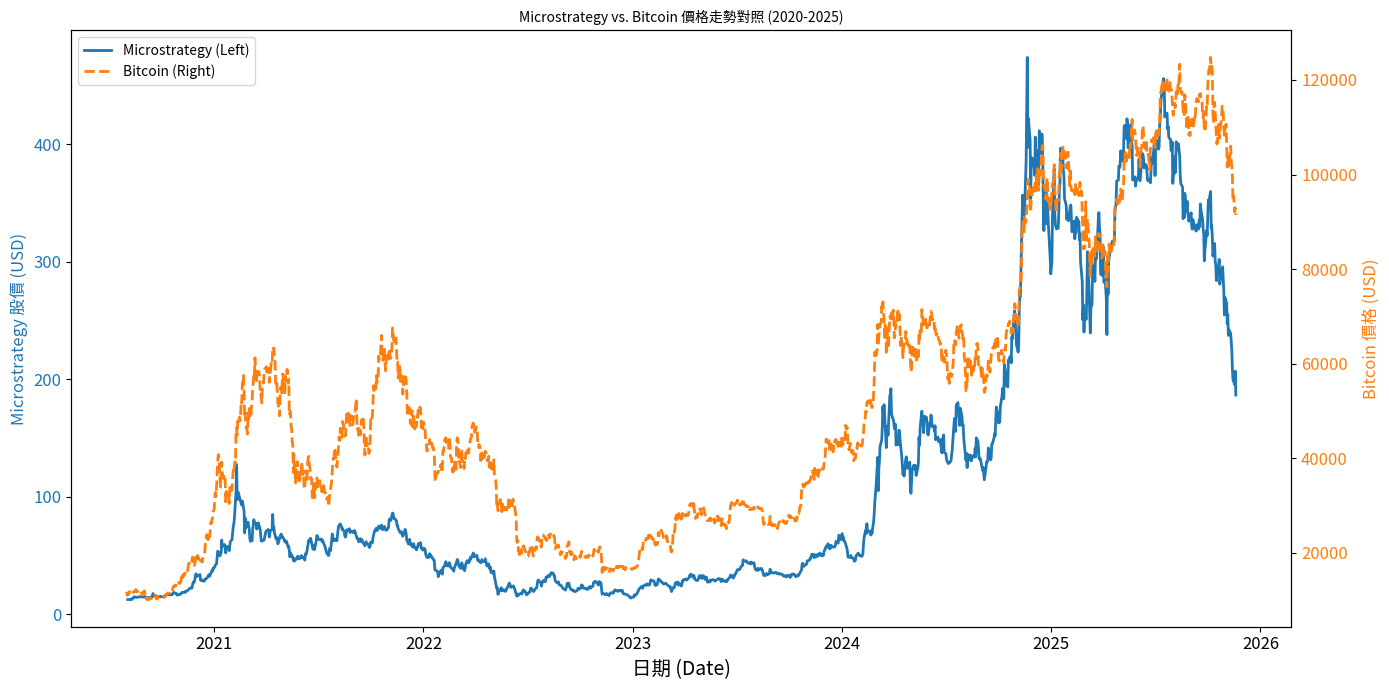

In [10]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from google.colab import files

# ----------------------------------------------------
# 1. 字型設定（Colab 版）
# ----------------------------------------------------
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
myfont = FontProperties(fname=font_path)
plt.rcParams['axes.unicode_minus'] = False

# ----------------------------------------------------
# 2. 畫圖
# ----------------------------------------------------
fig, ax1 = plt.subplots(figsize=(14, 7))

# 左軸：MSTR
color_mstr = 'tab:blue'
ax1.set_xlabel('日期 (Date)', fontproperties=myfont, fontsize=14)
ax1.set_ylabel('Microstrategy 股價 (USD)',
               color=color_mstr, fontproperties=myfont, fontsize=12)

line1 = ax1.plot(Micro.index, Micro['MSTR'], color=color_mstr,
                 label='Microstrategy (Left)', linewidth=2)

ax1.tick_params(axis='y', labelcolor=color_mstr)

# 右軸：BTC
ax2 = ax1.twinx()
color_btc = 'tab:orange'
ax2.set_ylabel('Bitcoin 價格 (USD)',
               color=color_btc, fontsize=12, fontproperties=myfont)

line2 = ax2.plot(BTC.index, BTC['BTC-USD'], color=color_btc,
                 label='Bitcoin (Right)', linewidth=2, linestyle='--')

ax2.tick_params(axis='y', labelcolor=color_btc)

# ----------------------------------------------------
# 3. 套用字體到所有刻度 tick labels
# ----------------------------------------------------
for label in ax1.get_xticklabels() + ax1.get_yticklabels():
    label.set_fontproperties(myfont)
    label.set_fontsize(12)

for label in ax2.get_yticklabels():
    label.set_fontproperties(myfont)
    label.set_fontsize(12)

# ----------------------------------------------------
# 4. 圖例 legend 套用中文字體
# ----------------------------------------------------
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left',
           fontsize=12, prop=myfont)

# ----------------------------------------------------
# 5. 標題
# ----------------------------------------------------
plt.title('Microstrategy vs. Bitcoin 價格走勢對照 (2020-2025)',
          fontsize=28, fontweight='bold', fontproperties=myfont)

fig.tight_layout()

# ----------------------------------------------------
# 6. 匯出 + 下載（Colab 專用）
# ----------------------------------------------------
filename = "price_trend_comparison.png"
plt.savefig(filename, dpi=300)
plt.show()

# files.download(filename)


#基礎敘述統計(mean,std,etc)


In [11]:
from scipy.stats import skew, kurtosis, jarque_bera
ticker=['BTC','MSTR']
df=yf.download(ticker,start='2020-08-01',end='2025-11-20')['Close'].dropna()

df = pd.concat([BTC, Micro], axis=1,keys=['BTC', 'MSTR'])
df_clean = df[['BTC', 'MSTR']]
print(df_clean)
#2. 計算對數報酬率 (Log Return)
df_ret = np.log(df_clean / df_clean.shift(1)).dropna()
df_ret.columns = ['BTC_Ret', 'MSTR_Ret']

# 3. 定義計算統計量的函式
def get_descriptive_stats(data):
  stats = pd.DataFrame(index=['Mean (%)', 'Std Dev', 'Min (%)', 'Max (%)',
                               'Skewness', 'Kurtosis', 'JB Stat', 'JB P-val'])

  for col in data.columns:
    series = data[col]
    jb_stat, jb_p = jarque_bera(series)

  # 這裡把 Mean 和 Min/Max 乘上 100 轉成百分比，比較好讀
  stats[col] = [
      series.mean() * 100,
      series.std(),
      series.min() * 100,
      series.max() * 100,
      skew(series),
      kurtosis(series), # 這裡算的是超額峰態 (Excess Kurtosis)，常態=0
      jb_stat,
      jb_p
          ]
  return stats

# 4. 產出統計資料表格
desc_table = get_descriptive_stats(df_ret)

print("=== 3.2 敘述性統計摘要表 (可以直接填入論文) ===")
print(desc_table.round(4)) # 取小數點後 4 位

[*********************100%***********************]  2 of 2 completed

                     BTC        MSTR
Ticker           BTC-USD        MSTR
Date                                
2020-08-01  11759.592773         NaN
2020-08-02  11053.614258         NaN
2020-08-03  11246.348633   12.366000
2020-08-04  11205.892578   12.332000
2020-08-05  11747.022461   12.395000
...                  ...         ...
2025-11-15  95549.148438         NaN
2025-11-16  94177.078125         NaN
2025-11-17  92093.875000  195.419998
2025-11-18  92948.875000  206.800003
2025-11-19  91465.992188  186.500000

[1937 rows x 2 columns]
=== 3.2 敘述性統計摘要表 (可以直接填入論文) ===
          MSTR_Ret
Mean (%)    0.1619
Std Dev     0.0562
Min (%)   -29.3255
Max (%)    22.1200
Skewness   -0.2495
Kurtosis    2.6840
JB Stat   324.2011
JB P-val    0.0000


#累積報酬

In [12]:
# 如果你已經有 df_analysis 就不用再下載
# df_analysis = pd.concat([BTC, Micro], axis=1, join='inner')
# df_analysis.columns = ['Bitcoin', 'MicroStrategy']

# 1. 計算日對數報酬，並轉成百分比（方便標軸寫 %）
ret = np.log(df_analysis).diff().dropna() * 100
ret.columns = ['BTC_ret', 'MSTR_ret']
# 如果你有設定中文字型，可以加上；沒有就拿掉 fontproperties= 那些
from matplotlib.font_manager import FontProperties
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
myfont = FontProperties(fname=font_path)
plt.rcParams['axes.unicode_minus'] = False  # 處理負號

plt.figure(figsize=(12, 6))

# 設定 bins 範圍，依你的資料調整
bins = np.linspace(-15, 15, 60)  # -15% ~ 15%

# 直方圖（密度）
sns.histplot(
    ret['MSTR_ret'],
    bins=bins,
    stat='density',
    alpha=0.5,
    label='MicroStrategy',
)

sns.histplot(
    ret['BTC_ret'],
    bins=bins,
    stat='density',
    alpha=0.5,
    label='Bitcoin',
)

# KDE 平滑曲線
sns.kdeplot(ret['MSTR_ret'], bw_adjust=1.0)
sns.kdeplot(ret['BTC_ret'], bw_adjust=1.0)

# 標題與標籤
plt.xlabel('每日漲跌幅 (%)', fontproperties=myfont, fontsize=12)
plt.ylabel('發生機率密度 (Density)', fontproperties=myfont, fontsize=12)

plt.legend(prop=myfont, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()

# 存檔（給論文用）
filename = "Risk_Distribution_MSTR_BTC.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

from google.colab import files
files.download(filename)


NameError: name 'df_analysis' is not defined

#4.1做定態檢定(ADF&PP)


In [13]:
try:
    from arch.unitroot import PhillipsPerron
    HAS_ARCH = True
except ImportError:
    HAS_ARCH = False
    print("警告: 未安裝 'arch' 套件，將跳過 PP 檢定。建議執行: pip install arch")

# 1. 下載資料
def get_data():
    print("正在下載資料...")
    tickers = ['MSTR', 'BTC-USD']
    data = yf.download(tickers, start='2020-01-01', end='2024-11-25')['Close']
    data = data.ffill().dropna()
    return data

# 2. ADF 檢定函數
def run_adf_test(series, name):
    result = adfuller(series)
    print(f"  [ADF] {name} - Stat: {result[0]:.4f}, P-value: {result[1]:.4f}")
    return result[0], result[1]

# 3. PP 檢定函數
def run_pp_test(series, name):
    if not HAS_ARCH:
        return np.nan, np.nan

    # PhillipsPerron 默認使用 'c' (constant, 含截距項)，這符合一般金融價格檢定
    pp = PhillipsPerron(series)
    print(f"  [PP ] {name} - Stat: {pp.stat:.4f}, P-value: {pp.pvalue:.4f}")
    return pp.stat, pp.pvalue

# 主程式
if __name__ == "__main__":
    df = get_data()

    # 計算對數報酬率
    df_log_ret = np.log(df / df.shift(1)).dropna()

    print("\n=== 開始進行定態檢定 (Stationarity Tests) ===")
    print("說明：若 P-value < 0.05，代表資料平穩 (Stationary)，拒絕虛無假設。\n")

    results = []

    # 定義要檢定的項目
    targets = [
        ('MSTR (Level)', df['MSTR']),
        ('MSTR (Return)', df_log_ret['MSTR']),
        ('BTC (Level)', df['BTC-USD']),
        ('BTC (Return)', df_log_ret['BTC-USD'])
    ]

    for label, series in targets:
        print(f"--- 分析: {label} ---")
        adf_stat, adf_p = run_adf_test(series, label)
        pp_stat, pp_p = run_pp_test(series, label)

        # 儲存結果以便查看 (可以用來填入 LaTeX)
        results.append({
            'Variable': label,
            'ADF Stat': adf_stat,
            'ADF P-val': adf_p,
            'PP Stat': pp_stat,
            'PP P-val': pp_p
        })

    print("\n=== 單跟檢定結果表格 ===")
    print(f"{'變數':<20} | {'ADF Stat':<10} | {'ADF P-val':<10} | {'PP Stat':<10} | {'PP P-val':<10}")
    print("-" * 70)
    for r in results:
        # 判斷星號
        adf_star = "***" if r['ADF P-val'] < 0.01 else "**" if r['ADF P-val'] < 0.05 else "*" if r['ADF P-val'] < 0.1 else ""
        pp_star = "***" if r['PP P-val'] < 0.01 else "**" if r['PP P-val'] < 0.05 else "*" if r['PP P-val'] < 0.1 else "" if not np.isnan(r['PP P-val']) else ""

        pp_stat_str = f"{r['PP Stat']:.4f}" if not np.isnan(r['PP Stat']) else "N/A"

        print(f"{r['Variable']:<20} | {r['ADF Stat']:.4f}{adf_star:<3} | {r['ADF P-val']:.4f}     | {pp_stat_str}{pp_star:<3} | {r['PP P-val']:.4f}")

    print("\n註: *** p<0.01, ** p<0.05, * p<0.1")

[*********************100%***********************]  2 of 2 completed

正在下載資料...



=== 開始進行定態檢定 (Stationarity Tests) ===
說明：若 P-value < 0.05，代表資料平穩 (Stationary)，拒絕虛無假設。

--- 分析: MSTR (Level) ---
  [ADF] MSTR (Level) - Stat: 2.8877, P-value: 1.0000
  [PP ] MSTR (Level) - Stat: 4.1583, P-value: 1.0000
--- 分析: MSTR (Return) ---
  [ADF] MSTR (Return) - Stat: -43.1977, P-value: 0.0000
  [PP ] MSTR (Return) - Stat: -43.2909, P-value: 0.0000
--- 分析: BTC (Level) ---
  [ADF] BTC (Level) - Stat: -0.2145, P-value: 0.9368
  [PP ] BTC (Level) - Stat: -0.0568, P-value: 0.9536
--- 分析: BTC (Return) ---
  [ADF] BTC (Return) - Stat: -13.7663, P-value: 0.0000
  [PP ] BTC (Return) - Stat: -44.6413, P-value: 0.0000

=== 單跟檢定結果表格 ===
變數                   | ADF Stat   | ADF P-val  | PP Stat    | PP P-val  
----------------------------------------------------------------------
MSTR (Level)         | 2.8877    | 1.0000     | 4.1583    | 1.0000
MSTR (Return)        | -43.1977*** | 0.0000     | -43.2909*** | 0.0000
BTC (Level)          | -0.2145    | 0.9368     | -0.0568    | 0.9536
BTC (Retu

#4.2Eagle-Granger兩步驟法(檢定長期共整合)

資料準備完成，樣本數: 1044
--------------------------------------------------
=== Engle-Granger 共整合檢定結果 ===
t-statistic: -2.5827
P-value: 0.2438
結論: P > 0.05，無法拒絕虛無假設 -> 不存在共整合關係 (兩者長期脫鉤)。
--------------------------------------------------


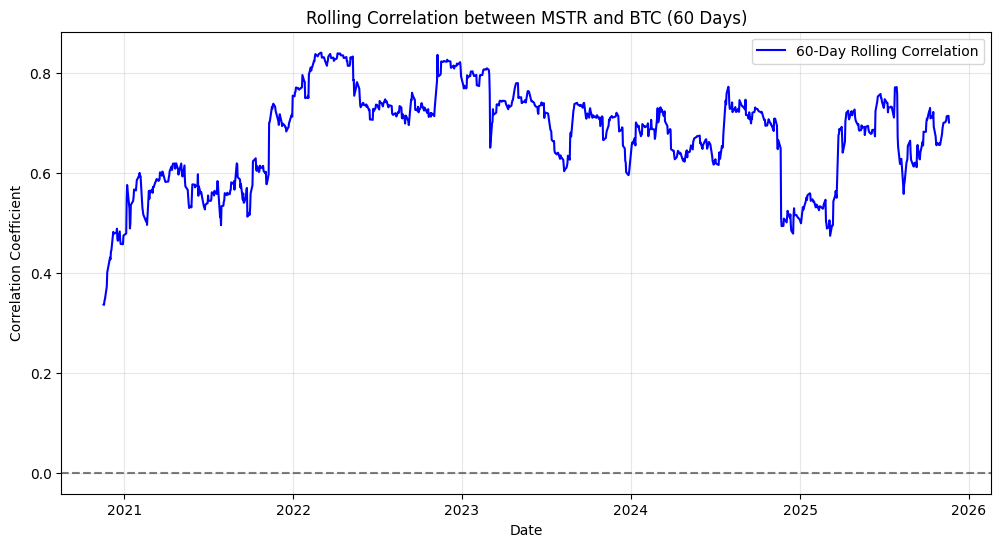

<Figure size 640x480 with 0 Axes>

In [14]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests, coint
import seaborn as sns

# ==========================================
# 0. 資料準備 (Data Preparation)
# ==========================================
# 假設您的 dataframe 叫 df，且已經有 'BTC' 和 'MSTR' 的價格

df = pd.concat([BTC, Micro], axis=1)

# 2. 重新命名欄位 (因為原本兩個都叫 'Close'，會混淆)
df.columns = ['BTC', 'MSTR']
df['BTC_Ret'] = np.log(df['BTC'] / df['BTC'].shift(1))
df['MSTR_Ret'] = np.log(df['MSTR'] / df['MSTR'].shift(1))

# 移除空值 (第一筆資料會是 NaN)
data = df.dropna()

print("資料準備完成，樣本數:", len(data))
print("-" * 50)
# ==========================================
# 1. 共整合檢定 (Cointegration Test - Engle-Granger)
# ==========================================
# 注意：必須使用「非平穩」的資料 (Level / Log Price)
# H0: 兩者之間 "不存在" 共整合關係 (無長期關係)

# 使用對數價格通常較好 (Log Price)
score, pvalue, _ = coint(np.log(data['MSTR']), np.log(data['BTC']))

print(f"=== Engle-Granger 共整合檢定結果 ===")
print(f"t-statistic: {score:.4f}")
print(f"P-value: {pvalue:.4f}")

if pvalue < 0.05:
    print("結論: P < 0.05，拒絕虛無假設 -> 存在共整合關係 (兩者長期連動)。")
else:
    print("結論: P > 0.05，無法拒絕虛無假設 -> 不存在共整合關係 (兩者長期脫鉤)。")

print("-" * 50)

# ==========================================
# 2. 滾動相關係數視覺化 (Rolling Correlation)
# ==========================================
# 使用 60 天 (約一季) 的窗口來觀察相關性變化

window_size = 60
rolling_corr = data['MSTR_Ret'].rolling(window=window_size).corr(data['BTC_Ret'])

plt.figure(figsize=(12, 6))
plt.plot(rolling_corr, label=f'{window_size}-Day Rolling Correlation', color='blue')
plt.axhline(0, color='black', linestyle='--', alpha=0.5)  # 0 軸線
plt.title(f'Rolling Correlation between MSTR and BTC ({window_size} Days)')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

filename = "Rolling Correlation between MSTR and BTC.png"
plt.savefig(filename, dpi=300)

# files.download(filename)

#4.3VAR模型


In [15]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR

# Step 1 建立差分價格序列

df = pd.concat([BTC, Micro], axis=1)

# 2. 重新命名欄位 (因為原本兩個都叫 'Close'，會混淆)
df.columns = ['BTC', 'MSTR']

df['dMSTR'] = np.log(df['MSTR']).diff()
df['dBTC']  = np.log(df['BTC']).diff()
df = df[['dMSTR', 'dBTC']].dropna()

# Step 2 Lag 選擇
model = VAR(df)
lag_selection = model.select_order(10)
print(lag_selection.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -13.13      -13.12   1.992e-06      -13.12
1      -13.15*     -13.12*  1.943e-06*     -13.14*
2       -13.15      -13.10   1.951e-06      -13.13
3       -13.14      -13.08   1.960e-06      -13.12
4       -13.14      -13.06   1.963e-06      -13.11
5       -13.14      -13.03   1.970e-06      -13.10
6       -13.13      -13.01   1.979e-06      -13.09
7       -13.14      -12.99   1.974e-06      -13.08
8       -13.13      -12.97   1.984e-06      -13.07
9       -13.13      -12.95   1.985e-06      -13.06
10      -13.12      -12.92   1.996e-06      -13.05
--------------------------------------------------


#4.3衝擊反應力函數

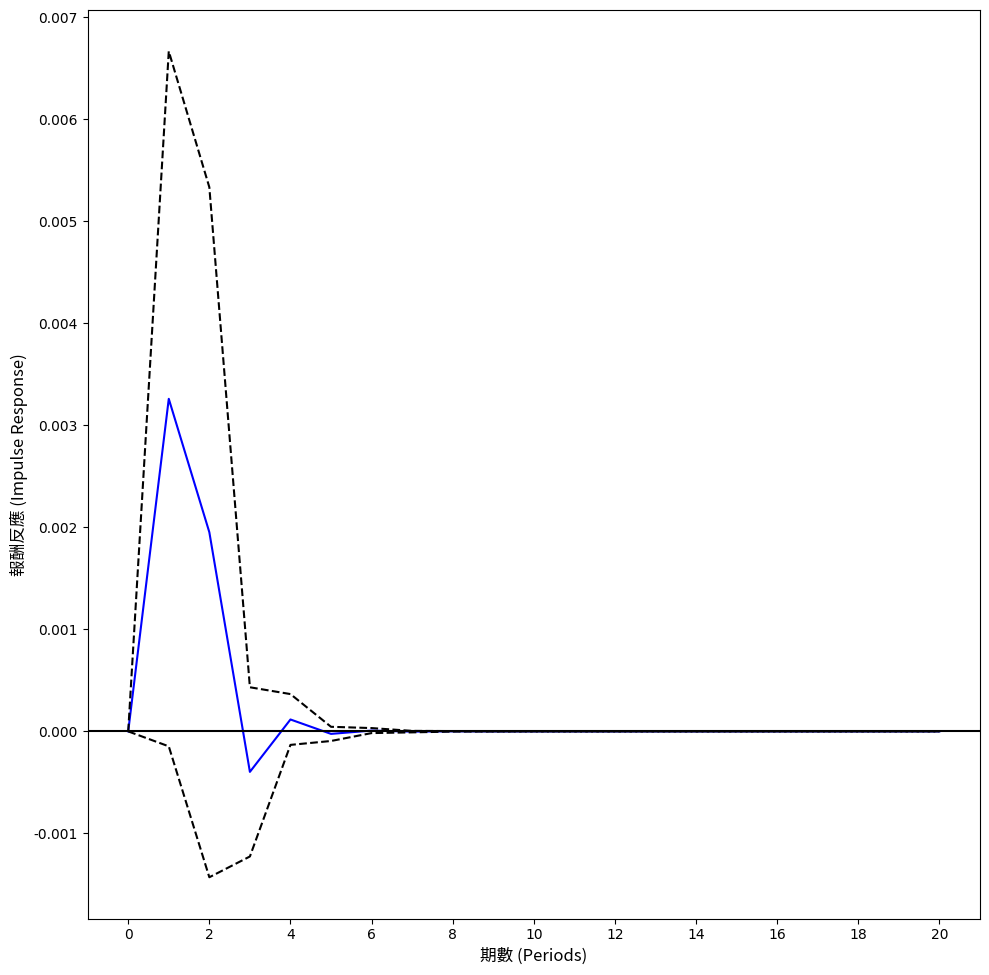

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

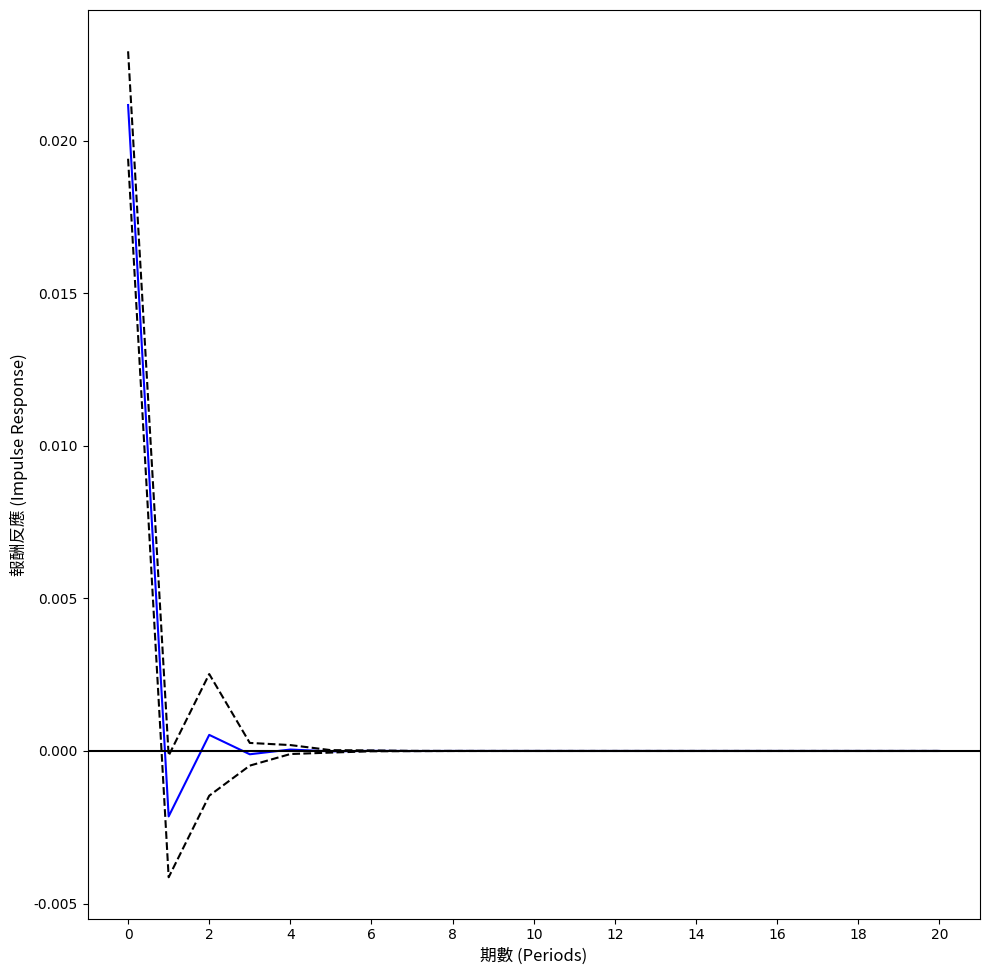

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
# AIC 推薦 lag = 1
# result = model.fit(2)
# print(result.summary())

# Step 3 脈衝反應分析（IRF）
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
from google.colab import files
# 如果前面已經定義過 myfont 就不用重複
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
myfont = FontProperties(fname=font_path)
plt.rcParams['axes.unicode_minus'] = False   # 負號顯示正常

irf = result.irf(20)   # 例如 20 期

# =========================
# 圖一：BTC 衝擊 → MSTR 反應
# =========================
fig = irf.plot(impulse='dBTC', response='dMSTR', orth=True)

ax = fig.axes[0]                # 取得唯一的子圖
fig.suptitle("")                # 拿掉上面的大標題
ax.set_title("")                # 拿掉子圖標題

# ★ 加上座標名稱
ax.set_xlabel('期數 (Periods)', fontproperties=myfont, fontsize=12)
ax.set_ylabel('報酬反應 (Impulse Response)', fontproperties=myfont, fontsize=12)

# （可選）讓 x 軸顯示整數期數
ax.set_xticks(range(0, 21, 2))

plt.tight_layout()
plt.savefig("IRF_BTC_to_MSTR.png", dpi=300, bbox_inches='tight')
plt.show()
files.download("IRF_BTC_to_MSTR.png")
plt.close()

# =========================
# 圖二：MSTR 衝擊 → BTC 反應
# =========================
fig = irf.plot(impulse='dMSTR', response='dBTC', orth=True)

ax = fig.axes[0]
fig.suptitle("")
ax.set_title("")

ax.set_xlabel('期數 (Periods)', fontproperties=myfont, fontsize=12)
ax.set_ylabel('報酬反應 (Impulse Response)', fontproperties=myfont, fontsize=12)
ax.set_xticks(range(0, 21, 2))

plt.tight_layout()
plt.savefig("IRF_MSTR_to_BTC.png", dpi=300, bbox_inches='tight')

plt.show()
files.download("IRF_MSTR_to_BTC.png")

plt.close()



#4.4Granger因果檢定

In [17]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests, coint
import seaborn as sns
# 如果是在 Google Colab 執行，需要這行來下載圖片
from google.colab import files

# ==========================================
# 0. 資料準備 (Data Preparation)
# ==========================================
# 假設 BTC 和 Micro 這兩個變數已經存在於您的環境中
df = pd.concat([BTC, Micro], axis=1)

# 2. 重新命名欄位
df.columns = ['BTC', 'MSTR']
df['BTC_Ret'] = np.log(df['BTC'] / df['BTC'].shift(1))
df['MSTR_Ret'] = np.log(df['MSTR'] / df['MSTR'].shift(1))

# 移除空值
data = df.dropna()

print("資料準備完成，樣本數:", len(data))
print("-" * 60)

# ==========================================
# 1. Granger 因果檢定 (Granger Causality) - 顯示所有結果
# ==========================================
max_lags = 5  # 設定要往前看幾天

# --- 定義一個小函式來印出漂亮的結果 ---
def print_granger_results(results, direction_text):
    print(f"\n=== 檢定: {direction_text} ===")
    print(f"{'Lag (滯後天數)':<15} | {'P-value':<10} | {'結果判定'}")
    print("-" * 45)

    for lag in range(1, max_lags + 1):
        # 取得 Chi-squared test 的 p-value (通常樣本大時看這個)
        p_value = results[lag][0]['ssr_chi2test'][1]

        # 判斷是否顯著
        if p_value < 0.05:
            status = "★ 顯著 (Significant)"
        else:
            status = "  不顯著"

        print(f"Lag {lag:<14} | {p_value:.4f}     | {status}")

# 執行檢定 A: BTC -> MSTR
gc_res_1 = grangercausalitytests(data[['MSTR_Ret', 'BTC_Ret']], maxlag=max_lags, verbose=False)
print_granger_results(gc_res_1, "BTC 是否領先 MSTR? (BTC -> MSTR)")

# 執行檢定 B: MSTR -> BTC
gc_res_2 = grangercausalitytests(data[['BTC_Ret', 'MSTR_Ret']], maxlag=max_lags, verbose=False)
print_granger_results(gc_res_2, "MSTR 是否領先 BTC? (MSTR -> BTC)")

print("-" * 60)

資料準備完成，樣本數: 1044
------------------------------------------------------------

=== 檢定: BTC 是否領先 MSTR? (BTC -> MSTR) ===
Lag (滯後天數)      | P-value    | 結果判定
---------------------------------------------
Lag 1              | 0.0944     |   不顯著
Lag 2              | 0.0751     |   不顯著
Lag 3              | 0.0984     |   不顯著
Lag 4              | 0.0995     |   不顯著
Lag 5              | 0.0632     |   不顯著

=== 檢定: MSTR 是否領先 BTC? (MSTR -> BTC) ===
Lag (滯後天數)      | P-value    | 結果判定
---------------------------------------------
Lag 1              | 0.9089     |   不顯著
Lag 2              | 0.6801     |   不顯著
Lag 3              | 0.4619     |   不顯著
Lag 4              | 0.3050     |   不顯著
Lag 5              | 0.3517     |   不顯著
------------------------------------------------------------


#4.5兩資產的累積報酬率比較


--- 檢查是否有空值 ---
BTC           0
MSTR        604
BTC_Ret       1
MSTR_Ret    893
dtype: int64


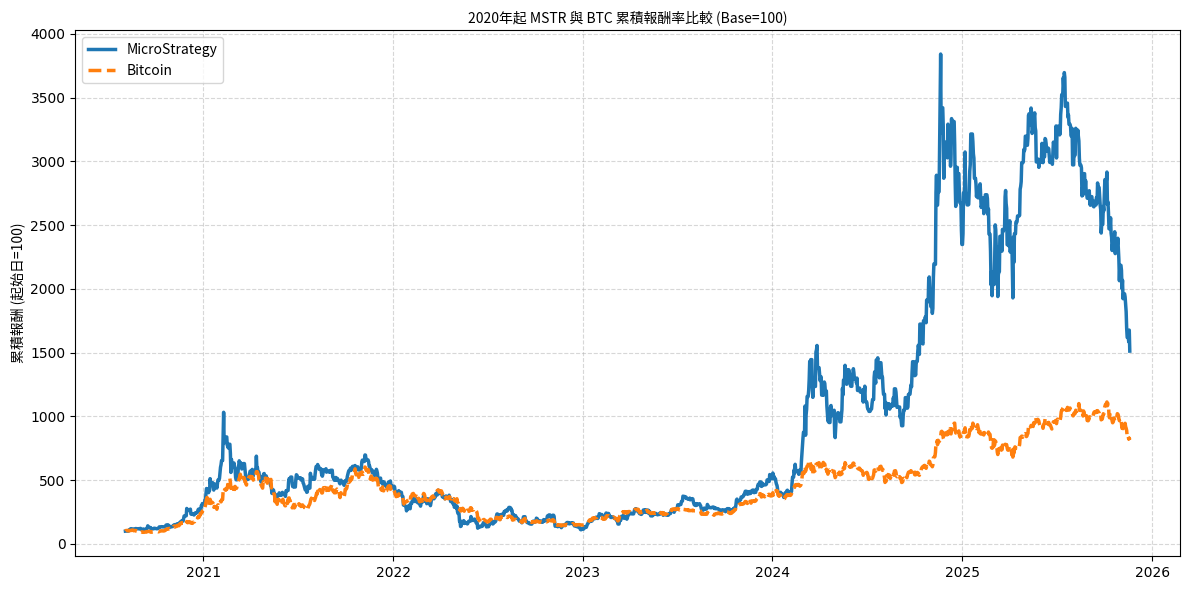

In [18]:
# 1. 先檢查一下資料狀況 (這步很重要，看看為什麼 MSTR 是空的)
print("\n--- 檢查是否有空值 ---")
print(df.isnull().sum())

# 2. 如果發現空值，我們先補齊或刪除 (通常 fillna 是個好選擇)
df_clean = df.fillna(method='ffill').dropna()

# 3. 重新計算 Base=100 (確保第一筆資料都有值)
# 使用 iloc[0] 鎖定第一天的價格當分母
normalized_df = df_clean / df_clean.iloc[0] * 100

# 4. 重新繪圖
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# 畫 MSTR (藍色實線)
plt.plot(normalized_df.index, normalized_df['MSTR'],
         label='MicroStrategy', color='tab:blue', linewidth=2.5)

# 畫 BTC (橘色虛線)
plt.plot(normalized_df.index, normalized_df['BTC'],
         label='Bitcoin', color='tab:orange', linewidth=2.5, linestyle='--')

plt.title('2020年起 MSTR 與 BTC 累積報酬率比較 (Base=100)', fontsize=16, fontproperties=myfont)
plt.ylabel('累積報酬 (起始日=100)', fontproperties=myfont)
plt.legend(prop=myfont, fontsize=12, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#4.5風險結構分析與槓桿倍數

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

正在下載資料...
資料準備完成，共 1333 筆交易日。


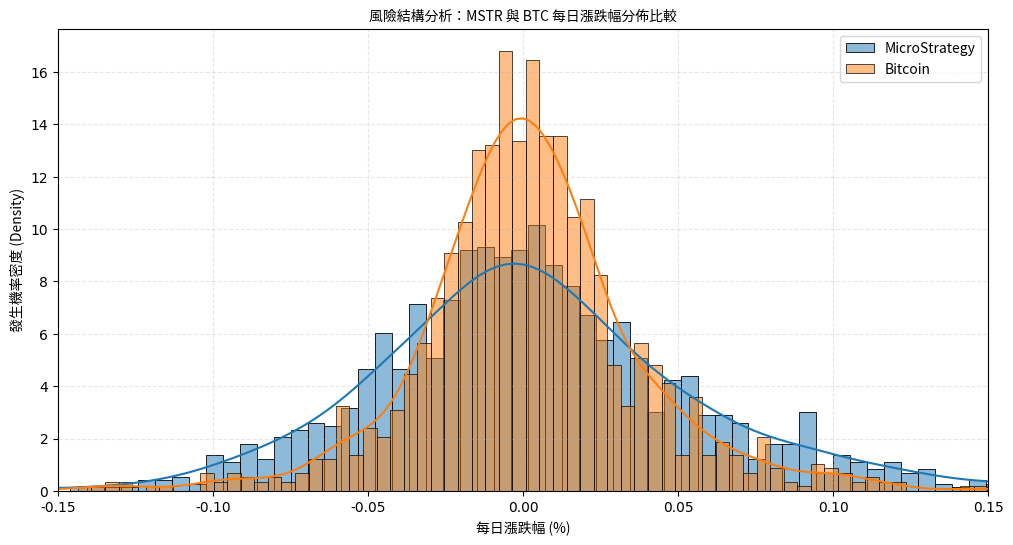

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

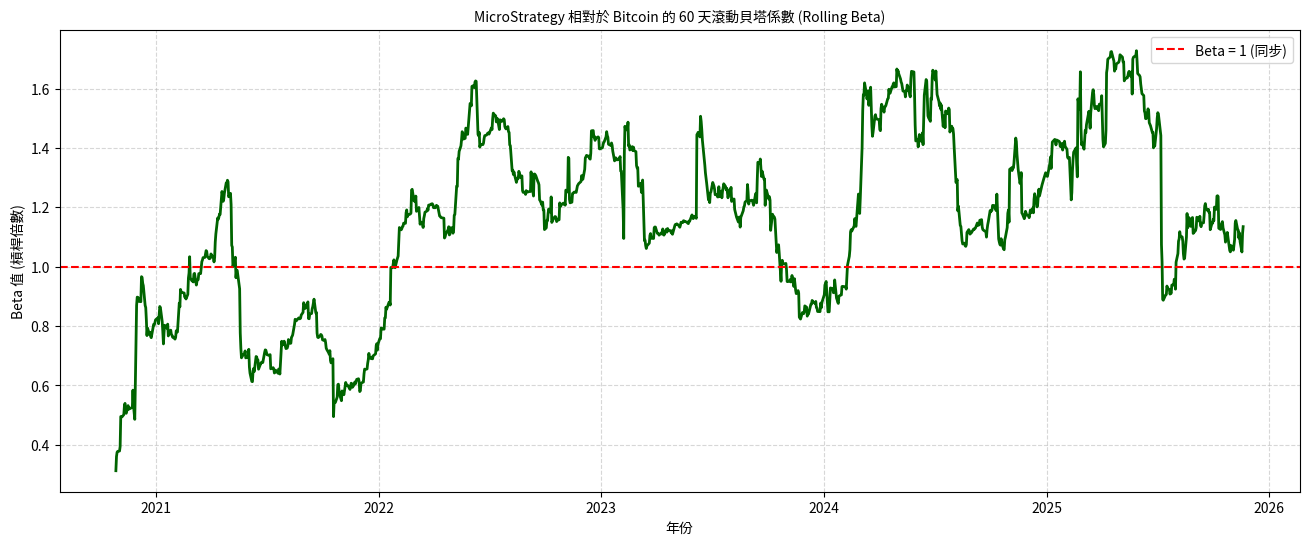

近期平均 Beta 值: 1.13


In [29]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
# ---------------------------------------------------------
# 1. 重新準備資料 (確保 df_analysis 存在)
# ---------------------------------------------------------
start = '2020-08-01'
end = '2025-11-20'

print("正在下載資料...")
BTC = yf.download('BTC-USD', start=start, end=end)['Close'].ffill().dropna()
Micro = yf.download('MSTR', start=start, end=end)['Close'].ffill().dropna()

# 合併兩者，使用 'inner' join 去除週末 (只保留共同交易日)
df_analysis = pd.concat([BTC, Micro], axis=1, join='inner')
df_analysis.columns = ['Bitcoin', 'MicroStrategy']

print(f"資料準備完成，共 {len(df_analysis)} 筆交易日。")

# ---------------------------------------------------------
# 2. 計算每日漲跌幅 & 畫圖
# ---------------------------------------------------------
daily_returns = df_analysis.pct_change().dropna()

# # 設定中文字型 (確保你有執行過之前的字型設定，若無請忽略 fontproperties 參數)
# # 如果字型報錯，把下面這行 fontproperties=myfont 拿掉即可
try:
     font_prop = myfont
except NameError:
     font_prop = None # 如果沒設定過字型，就用預設

# === 圖表 A: 波動率分佈直方圖 (Histogram) ===
plt.figure(figsize=(12, 6))
sns.histplot(daily_returns['MicroStrategy'], bins=100, color='tab:blue',
              label='MicroStrategy', kde=True, stat="density", alpha=0.5)
sns.histplot(daily_returns['Bitcoin'], bins=100, color='tab:orange',
             label='Bitcoin', kde=True, stat="density", alpha=0.5)

plt.title('風險結構分析：MSTR 與 BTC 每日漲跌幅分佈比較', fontsize=16, fontproperties=font_prop)
plt.xlabel('每日漲跌幅 (%)', fontproperties=font_prop)
plt.ylabel('發生機率密度 (Density)', fontproperties=font_prop)
plt.xlim(-0.15, 0.15)
plt.legend(prop=font_prop, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)

filename = "MSTR和BTC美日漲跌幅分布比較.png"
plt.savefig(filename, dpi=300)
plt.show()
files.download(filename)

#=== 圖表 B: 滾動 Beta 值 (Rolling Beta) ===
window = 60
rolling_cov = daily_returns['MicroStrategy'].rolling(window=window).cov(daily_returns['Bitcoin'])
rolling_var = daily_returns['Bitcoin'].rolling(window=window).var()
rolling_beta = rolling_cov / rolling_var

plt.figure(figsize=(16,6))
plt.plot(rolling_beta.index, rolling_beta, color='darkgreen', linewidth=2)
plt.axhline(y=1, color='red', linestyle='--', label='Beta = 1 (同步)')
plt.title('MicroStrategy 相對於 Bitcoin 的 60 天滾動貝塔係數 (Rolling Beta)', fontsize=16, fontproperties=font_prop)
plt.xlabel('年份', fontproperties=font_prop)
plt.ylabel('Beta 值 (槓桿倍數)', fontproperties=font_prop)
plt.legend(prop=font_prop, fontsize=20)
plt.grid(True, linestyle='--', alpha=0.5)

#  讓座標字變大
plt.xticks(fontsize=30, fontproperties=font_prop)
plt.yticks(fontsize=30, fontproperties=font_prop)

filename = "MSTR and BTC leverage.png"
plt.savefig(filename, dpi=300)
plt.show()
# files.download(filename)
print(f"近期平均 Beta 值: {rolling_beta.iloc[-1]:.2f}")

#對數報酬率迴歸


                            OLS Regression Results                            
Dep. Variable:               MSTR_ret   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     1227.
Date:                Fri, 05 Dec 2025   Prob (F-statistic):          5.58e-191
Time:                        08:38:53   Log-Likelihood:                 2319.2
No. Observations:                1332   AIC:                            -4634.
Df Residuals:                    1330   BIC:                            -4624.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.273      0.7

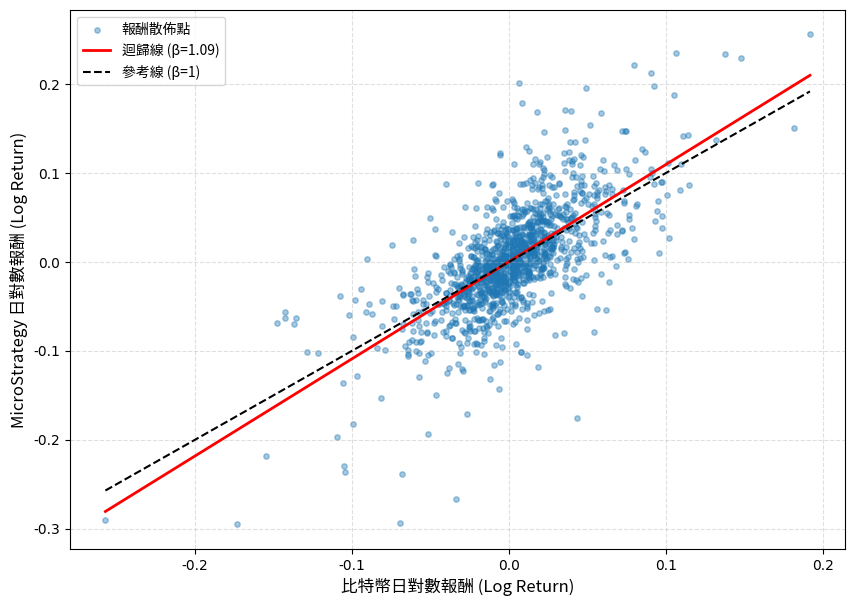

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
import statsmodels.api as sm
from matplotlib.font_manager import FontProperties

# 設定中文字型路徑 (請確保此路徑在您的環境是正確的)
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
myfont = FontProperties(fname=font_path)
plt.rcParams['axes.unicode_minus'] = False  # 處理負號顯示問題

# ----------------------------------------
# 1. 準備資料
# ----------------------------------------
# ★修正重點：使用對數報酬 (Log Returns) 而非價格差
# 這能確保資料尺度正確，且符合計量經濟學標準
btc_ret = np.log(df_analysis['Bitcoin']).diff().dropna()
mstr_ret = np.log(df_analysis['MicroStrategy']).diff().dropna()

# 對齊資料
data = pd.concat([btc_ret, mstr_ret], axis=1).dropna()
data.columns = ['BTC_ret', 'MSTR_ret']

# ----------------------------------------
# 2. OLS 回歸：MSTR = alpha + beta * BTC
# ----------------------------------------
X = sm.add_constant(data['BTC_ret'])
y = data['MSTR_ret']

# 執行回歸
model = sm.OLS(y, X).fit()
beta = model.params['BTC_ret']
alpha = model.params['const']

# 印出結果
print(model.summary())
print(f"\nEstimated beta = {beta:.4f}")

# ----------------------------------------
# 3. 畫散佈圖 + 回歸線 + β=1 參考線
# ----------------------------------------
plt.figure(figsize=(10, 7))

# 散佈圖 (Scatter Plot)
plt.scatter(data['BTC_ret'], data['MSTR_ret'],
            alpha=0.4, s=15, label='報酬散佈點')

# 繪製回歸線 (Regression Line)
# 建立 X 軸的模擬點，範圍涵蓋資料的最小值到最大值
x_vals = np.linspace(data['BTC_ret'].min(), data['BTC_ret'].max(), 200)
y_hat = alpha + beta * x_vals
plt.plot(x_vals, y_hat, color='red', linewidth=2, label=f'迴歸線 (β={beta:.2f})')

# 繪製 β = 1 的參考線 (45度線)
# 用來比較是否具備槓桿效果 (若紅線比黑線陡，代表 β > 1)
plt.plot(x_vals, x_vals, color='black', linestyle='--', linewidth=1.5, label='參考線 (β=1)')

# 標題與座標軸
#plt.title("MicroStrategy 與比特幣日對數報酬散佈圖", fontsize=14, fontproperties=myfont)
plt.xlabel("比特幣日對數報酬 (Log Return)", fontsize=12, fontproperties=myfont)
plt.ylabel("MicroStrategy 日對數報酬 (Log Return)", fontsize=12, fontproperties=myfont)

# 格線與圖例
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(prop=myfont, fontsize=10)

# ----------------------------------------
# 4. 匯出圖片
# ----------------------------------------
plt.savefig("MSTR_BTC_Leverage_Scatter.png", dpi=300, bbox_inches='tight')
plt.show()
files.download('MSTR_BTC_Leverage_Scatter.png')